In [3]:
import os
# import supervision as sv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

import pycocotools.mask as mask_util
from groundingdino.util.inference import load_model, load_image, predict, annotate

In [4]:
CONFIG_PATH = "groundingdino/config/GroundingDINO_SwinT_OGC.py"
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join("weight", WEIGHTS_NAME)
detection_model = load_model(CONFIG_PATH, WEIGHTS_PATH)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
from torchvision.ops import box_convert

IMAGE_PATH = "/home/data/mvtec/cable/test/missing_cable/000.png"
# IMAGE_PATH = "/home/data/mvtec/hazelnut/test/crack/000.png"
SAVE_PATH = "./test/"
TEXT_PROMPT = "anomaly"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.3

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=detection_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)
boxes_ = boxes * 1024
xyxy = box_convert(boxes=boxes_, in_fmt="cxcywh", out_fmt="xyxy").tolist()
xyxy
# annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# %matplotlib inline
# sv.plot_image(annotated_frame, (8, 8))

/home/yyamada/miniconda3/envs/SAA/lib/python3.9/site-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/yyamada/miniconda3/envs/SAA/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


[[634.8584594726562, 462.8417053222656, 839.6134643554688, 645.3211059570312],
 [209.6402587890625, 411.4610290527344, 549.51513671875, 737.047119140625],
 [298.75799560546875,
  449.1960754394531,
  497.27618408203125,
  654.0049438476562],
 [532.6983032226562, 422.1690979003906, 871.6762084960938, 763.720947265625]]

# 結果の可視化

In [6]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

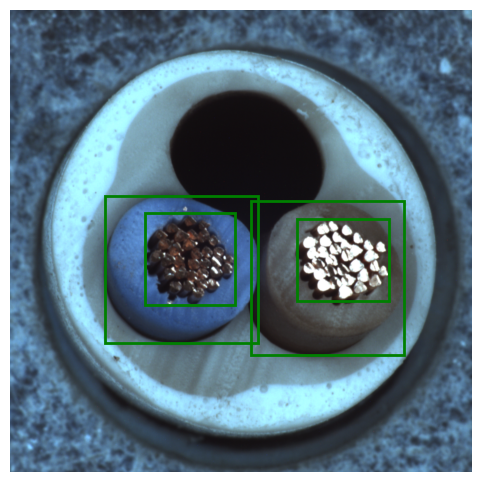

In [7]:
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(image)

for box in xyxy:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

# マスク生成

In [8]:
import cv2
import numpy as np

# Read the image
image = cv2.imread(IMAGE_PATH)

# Get the dimensions of the image
height, width, _ = image.shape

# Create a black image with the same dimensions
mask = np.zeros((height, width), dtype=np.uint8)

# Define the bounding boxes
bounding_boxes = [
    [634.8584594726562, 462.8417053222656, 839.6134643554688, 645.3211059570312],
    [209.6402587890625, 411.4610290527344, 549.51513671875, 737.047119140625],
    [298.75799560546875, 449.1960754394531, 497.27618408203125, 654.0049438476562],
    [532.6983032226562, 422.1690979003906, 871.6762084960938, 763.720947265625]
]

# Fill in the bounding boxes with white
for bbox in bounding_boxes:
    start_point = (int(bbox[0]), int(bbox[1]))  # Top left corner
    end_point = (int(bbox[2]), int(bbox[3]))  # Bottom right corner
    color = 255  # White
    thickness = -1  # Fill
    mask = cv2.rectangle(mask, start_point, end_point, color, thickness)

# Save the mask
os.makedirs(SAVE_PATH, exist_ok=True)
MASK_PATH = os.path.join(SAVE_PATH, 'mask.png')
cv2.imwrite(MASK_PATH, mask)

True

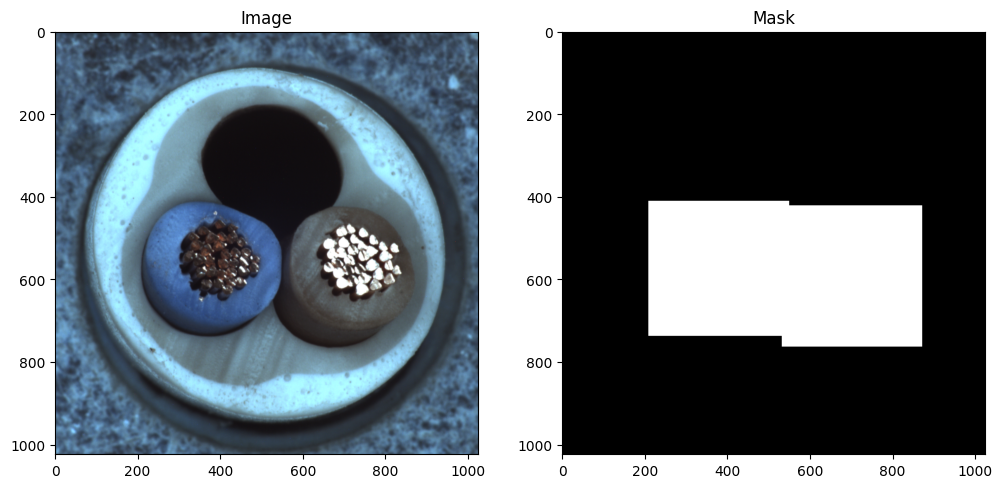

In [9]:
import cv2
import matplotlib.pyplot as plt

# Load the image and mask using cv2
img_cv2 = cv2.imread(IMAGE_PATH)
mask_cv2 = cv2.imread(MASK_PATH, cv2.IMREAD_GRAYSCALE)

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Display the image and mask
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img_rgb)
axs[0].set_title('Image')
axs[1].imshow(mask_cv2, cmap='gray')
axs[1].set_title('Mask')
plt.show()

# BBからpro計算

In [10]:
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from numpy import ndarray
from PIL import Image
from skimage import measure
from sklearn.metrics import auc
from statistics import mean

def compute_pro(gt_masks: ndarray, amaps=None, boxes=None, scale_factor: float = 0.25, num_th: int = 200) -> None:
    """Compute the area under the curve of per-region overlaping (PRO) and 0 to 0.3 FPR
    Args:
        category (str): Category of product
        gt_masks (ndarray): All binary masks in test. gt_masks.shape -> (num_test_data, h, w)
        amaps (ndarray): All anomaly maps in test. amaps.shape -> (num_test_data, h, w)
        boxes (list): All boxes in test. len(boxes[i]) -> 4
        num_th (int, optional): Number of thresholds
    """
    if boxes is not None: # BBの座標から塗りつぶしたマスクを生成
        num_test_data, height, width = gt_masks.shape
        amaps = np.zeros((num_test_data, height, width), dtype=np.uint8)
        for bbox in boxes:
            start_point = (int(bbox[0] * scale_factor), int(bbox[1] * scale_factor)) # Top left corner
            end_point = (int(bbox[2] * scale_factor), int(bbox[3] * scale_factor)) # Bottom right corner
            amaps[0, start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1
        
    assert isinstance(amaps, ndarray), "type(amaps) must be ndarray"
    assert isinstance(gt_masks, ndarray), "type(gt_masks) must be ndarray"
    assert amaps.ndim == 3, "amaps.ndim must be 3 (num_test_data, h, w)"
    assert gt_masks.ndim == 3, "gt_masks.ndim must be 3 (num_test_data, h, w)"
    assert amaps.shape == gt_masks.shape, "amaps.shape and gt_masks.shape must be same"
    assert set(gt_masks.flatten()) == {0, 1}, "set(gt_masks.flatten()) must be {0, 1}"
    assert isinstance(num_th, int), "type(num_th) must be int"

    df = pd.DataFrame([], columns=["pro", "fpr", "threshold"])
    binary_amaps = np.zeros_like(amaps, dtype=bool)

    min_th = amaps.min()
    max_th = amaps.max()
    delta = (max_th - min_th) / num_th

    for th in np.arange(min_th, max_th, delta):
        # 2値化処理(segmentation)
        binary_amaps[amaps <= th] = 0
        binary_amaps[amaps > th] = 1

        # pro計算
        pros = []
        for binary_amap, mask in zip(binary_amaps, gt_masks):
            for region in measure.regionprops(measure.label(mask)):
                axes0_ids = region.coords[:, 0]
                axes1_ids = region.coords[:, 1]
                tp_pixels = binary_amap[axes0_ids, axes1_ids].sum()
                pros.append(tp_pixels / region.area)

        # fpr計算
        inverse_masks = 1 - gt_masks
        fp_pixels = np.logical_and(inverse_masks, binary_amaps).sum()
        fpr = fp_pixels / inverse_masks.sum()

        df = df.append({"pro": mean(pros), "fpr": fpr, "threshold": th}, ignore_index=True)

    # Normalize FPR from 0 ~ 1 to 0 ~ 0.3
    df = df[df["fpr"] < 0.3]
    df["fpr"] = df["fpr"] / df["fpr"].max()
    
    # print(df)

    pro_auc = auc(df["fpr"], df["pro"])
    return pro_auc, pros

In [11]:
image_size = 256
crop_size = 256
original_size = 1024
scale_factor = crop_size / original_size

gt = Image.open(MASK_PATH)

gt_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor()])

gt = gt_transforms(gt)
gt = gt.bool()
gt = gt.squeeze(0).cpu().numpy().astype(int)

gt = gt[np.newaxis, :, :]
# print(gt.shape) # (1, 256, 256)

compute_pro(gt, amaps=None, boxes=xyxy, scale_factor=scale_factor)

(nan, [0.9639412997903564])

bbの場合2値のためaucはでない